----
# Logistic Model: Basic Model
----
### Summary:
Using the MNIST Sign Language Dataset to build a basic Logistic Regression Classification model which will acts as a baseline model.

### Data Overview:
- **Dataset**: MNIST Sign Language Dataset
- **Number of Samples**: Approximately 1400 images per character
- **Image Dimensions**: Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Loading**:
   - Load the MNIST Sign Language dataset.
   - Split the data into training and validation sets.

- **Data Visualisation**:
   - Visualsing single image for each letter as well as the mean of all images for each letter.
   - Exploring effects of thresholding.

- **Building the Logistic Regression Model**:
   - Build a Logistic Regression model.
   - Train the model using the training dataset.

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.
   - Explore odds ratio for each letter to unpack what each model has learnt about a given letter.


## Set Up


In [40]:
# List of imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
import joblib


## Data Loading


In [4]:
# connect to google drive -> required for input image later
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# X = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/X.pkl' )
# y = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/y.pkl' )
X  = joblib.load( '../../model/my_files/X.pkl' )
y = joblib.load( '../../model/my_files/y.pkl' )

In [7]:
# Both to be used at a later time to assign meaningful values to the nuermic target class
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [8]:
# To store unique class values - to be used later in loops
unique_values, value_counts = np.unique(y, return_counts=True)

## Utility Functions


In [9]:
my_image = X.reshape(-1,28,28)
my_class = y

In [10]:
# Creating a function to compare exponentials of coefficients with the mean image for a given letter
def assess_coef(coef, letter='a'):
    '''
    Overview:
    Plots the mean image of a given letter and the odds ratio image based on model coefficients.

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            -  mean image of given letter
            - 'odds ratio' pixel image for each given letter

    '''
    # Data set contains no data for letters j and z, to raise error message if input letter is j/z
    if letter.lower() in ('j', 'z'):
        raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:

        my_image = X.reshape(-1,28,28)
        my_class = y

        fig, axes = plt.subplots(1,2, figsize=(20, 10))

        # get index of letter as class is int data type
        idx1 = alphabet.index(letter.lower())

        plt.subplot(1,2,1)
        plt.imshow(np.mean(my_image[my_class==idx1], axis = 0) ,cmap='gray')
        plt.title(f'Mean of {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,2,2)
        # Using cmap show the odds ratio -> cases where odds ratio is > 1 means certain pixel increases the odss of the image being classified as the target letter
        #                                -> cases where odds ratio is < 1 means certain pixel decreses the odds of the image being classified as the target letter
        plt.imshow(np.exp(coef[idx1]).reshape(28,28),cmap='BuPu')
        # added positioning to make colour bar same height as image
        plt.colorbar(label='Odds Ratio',fraction=0.046, pad=0.04)
        plt.title(f'Odds Ratio for {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        plt.show()

In [25]:
def plt_train_test_score(tuning_param,train_score, val_score, log = False, param_name='Hyper-parameter'):
    '''
    Description 
    -----------
        Outputs graph to compare accuracy score between train and test set

    Paramters
    ---------
        tuning_param: list of hyper-parameter values
        train_score: list of training scores
        test_score: list of test scores
        log = if x scale should be 'logged', default = FALSE
        param_name = name of hyper-parameter, default = HYPER-PARAMETER

    Returns
    -------
        Line graph with two lines :
            - training accuracy score across range of hyper-parameter
            - test accuracy score across range of hyper-parameter
    '''

    min_idx = np.abs(np.array(train_score)- np.array(val_score)).argmin()

    fig, ax = plt.subplots()
    ax.plot(tuning_param, train_score, color = 'teal', marker = '.',label='Train scores')
    ax.plot(tuning_param, val_score, color = 'darkmagenta', marker = '.', label = 'Validation score')
    ax.axvline(tuning_param[min_idx], linestyle= '--', color = 'palevioletred', label = 'Guideline - Min Diff')

    if log == True:
        ax.set_xscale('log')
    else:
        pass

    ax.set_title(f'Tuning for {param_name}', fontweight= 'bold') # if no param name is passed just show hyperparamater tuning as title
    ax.set_xlabel(f'Range of {param_name} values') # if no param name is passed just show hyperparamater range as x-axis label
    ax.set_ylabel('Accuracy Score')
    ax.spines[['right', 'top']].set_visible(False)
    plt.legend()
    plt.show()


## Data Visualisation

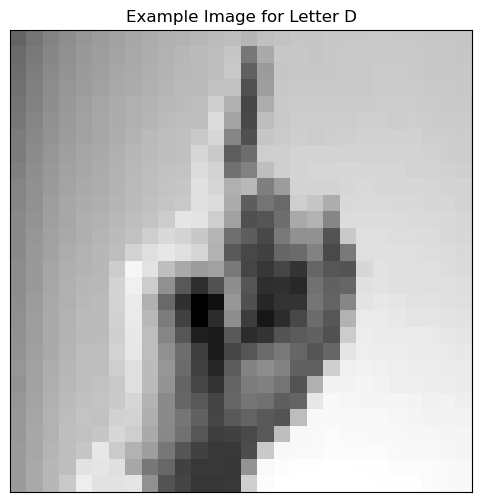

In [11]:
# To show a single image example usinf plt.imshow
plt.figure(figsize=(6, 6))
# Using cmap to convert colours to greyscale -> coloured image doesn't seem to provide any additional details
plt.imshow(my_image[0], cmap="gray")
plt.title(f'Example Image for Letter {alphabet[my_class[0]].upper()}')
plt.xticks([])
plt.yticks([])
plt.show()

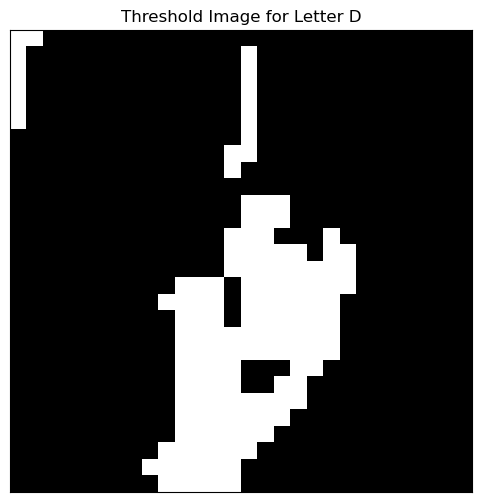

In [12]:
# Applying thresholding using np.where to force pixel intensity to 0 (black) for cases where pixel intensity is greater than 180
normalised = np.where(my_image[0] > 120,0,1)
plt.figure(figsize=(6, 6))
plt.imshow(normalised, cmap="gray")
plt.title(f'Threshold Image for Letter {alphabet[my_class[0]].upper()}')
plt.xticks([])
plt.yticks([])
plt.show()

**Comments**:

To me, thresholding doesn't look like it would be helpful for this dataset.

If I look below, there is varying pixel intensity inside the hand therfore only using two colours black and white will not help this model. A strict thresholding to black and white will most likely confuse the model as there are subtle differences between some letters which is harder to capture if we use thresholding. For example:

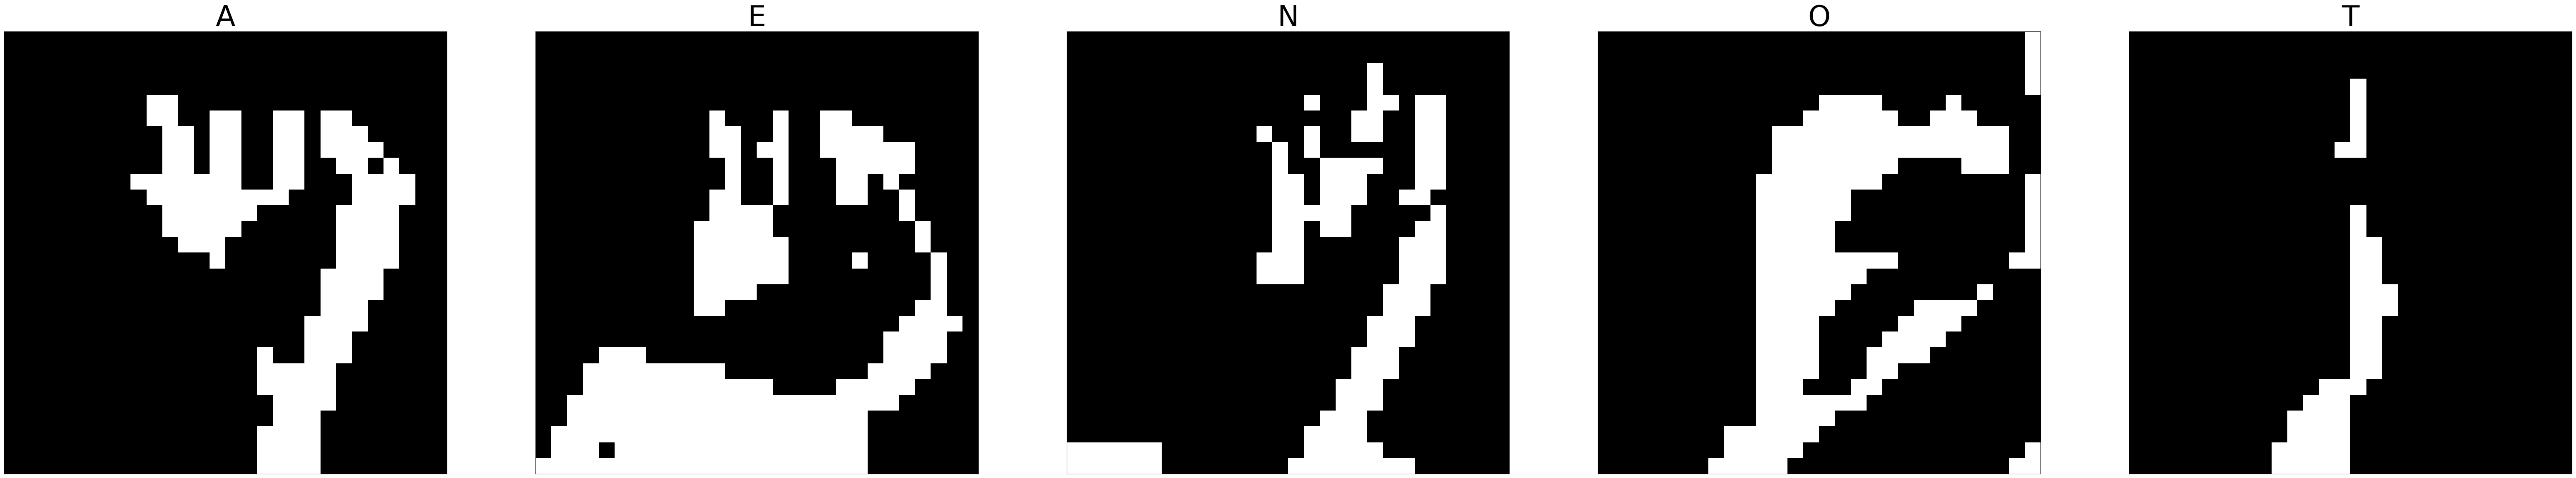

In [13]:
# creating a subplot canvas with 1 row and 5 plots, each plot has figure size 80 120
fig, axes = plt.subplots(1,5, figsize=(80, 120))
# grabbing examples of letters where the sign is similar
ae_idx = [0,4,12,13,18]

# using zip to combine the index of my ae_idx (target) and is corresponding plot position (ax) into a tuple
for target, ax in zip(ae_idx, axes.ravel()):
    # Passing in [my_class == target] to my image -> filters images to only retrieve images where the label is in ae_idx list ^
    # [0] to retrieve only the first image for each letter
    normalised = np.where(my_image[my_class==target][0] > 120,0,1)
    ax.imshow(normalised, cmap = 'gray')
    # using alphabet array and target as an index to set the title for each subplot
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


### Assessing the Images


##### Printing a single image for each character:

In [14]:
fig, axes = plt.subplots(6,4, figsize=(80, 120))

for target, ax in zip(unique_values, axes.ravel()):
    ax.imshow(my_image[my_class==target][0], cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


##### Printing mean image for each character:
This allows us to assess what features(pixels) the model are most likely to "see" as the most defining for each class. We will revisit this later when we assess the performance of the Logistic Model.

In [15]:
fig, axes = plt.subplots(6, 4, figsize=(80, 120))
for target, ax in zip(unique_values, axes.ravel()):
    # calculating the mean of each class along the rows
    #myimage[my_class == target] has shape (~1400, 784) so we calculate mean pixel value for each of the 784 pixels across all ~1400 instances
    ax.imshow(np.mean(my_image[my_class==target], axis = 0), cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Building the Logistic Regression Model

In [27]:
# Flattening each image back to 784 pixels for the Logistic Regression model
flattened_dataset = my_image.reshape(my_image.shape[0],28 * 28)

In [28]:
X = flattened_dataset

# Splitting my dataset into train and test datasets (80% = train/20%= test)
# Setting random state to allow replciation of "random" numbers
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify= y)

In [29]:
# Using saga algorithm with lasso penalty, saga algorithm works best for larger datasets, alpha set to to 0.01
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)

my_model.fit(X_train, y_train)

/Users/simybasra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [31]:
# getting predicted y = to be used for confusion matrix further on in notebook
pred_y = my_model.predict(X_val)

In [32]:
print(f'train score: {my_model.score(X_train, y_train)}')
print(f'val_score:{my_model.score(X_val,y_val)}')

train score: 0.9999639002202086
val_score:0.9998556165174703



**Comment:**
Difference between the train and test score is very low (0.0005), suggesting a good, robust model.


In [34]:
# Using joblib to create .pkl file to store model as my model has a runtime of ~ 3 mins 30 seconds
import joblib

joblib.dump(my_model, '../../model/my_files/my_log_reg_basic.pkl')

['../../model/my_files/my_log_reg_basic.pkl']

In [35]:
my_final_model = joblib.load('../../model/my_files/my_log_reg_basic.pkl')

In [36]:
# Sanity check:
print(f'train score: {my_final_model.score(X_train, y_train)}')
print(f'val_score:{my_final_model.score(X_val,y_val)}')

train score: 0.9999639002202086
val_score:0.9998556165174703


## Model Evaluation

### Confusion Matrix:
Plotting a confusion matrix shows us the number of correctly and incorrecly classified images of the model.Since performance of the final model (my_model2) is very high we see a low number of misclassifications.

In [37]:
pred_y = my_final_model.predict(X_val)

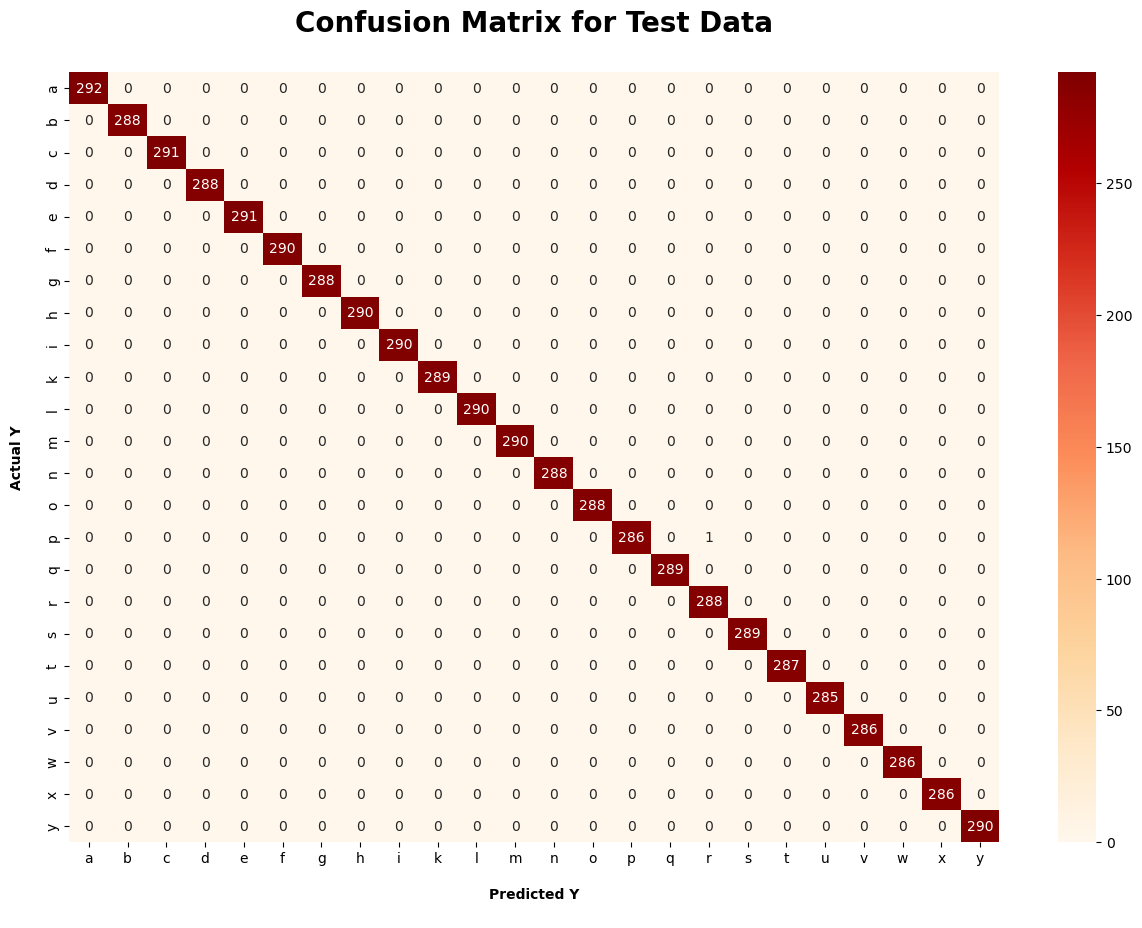

In [38]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Assessment of Accuracy:**
The final model shows us a very high accuracy for both training and test data, it would be interesting to see what pixels (features) are the most defining for each letter when it comes to classification. To do this, I will assess the coefficients of the logistic models for each letter.

### Visualising Misclassifications

In [41]:
incorrect_photos = (y_val != pred_y)

In [46]:
X_val = X_val.reshape(-1,28,28)

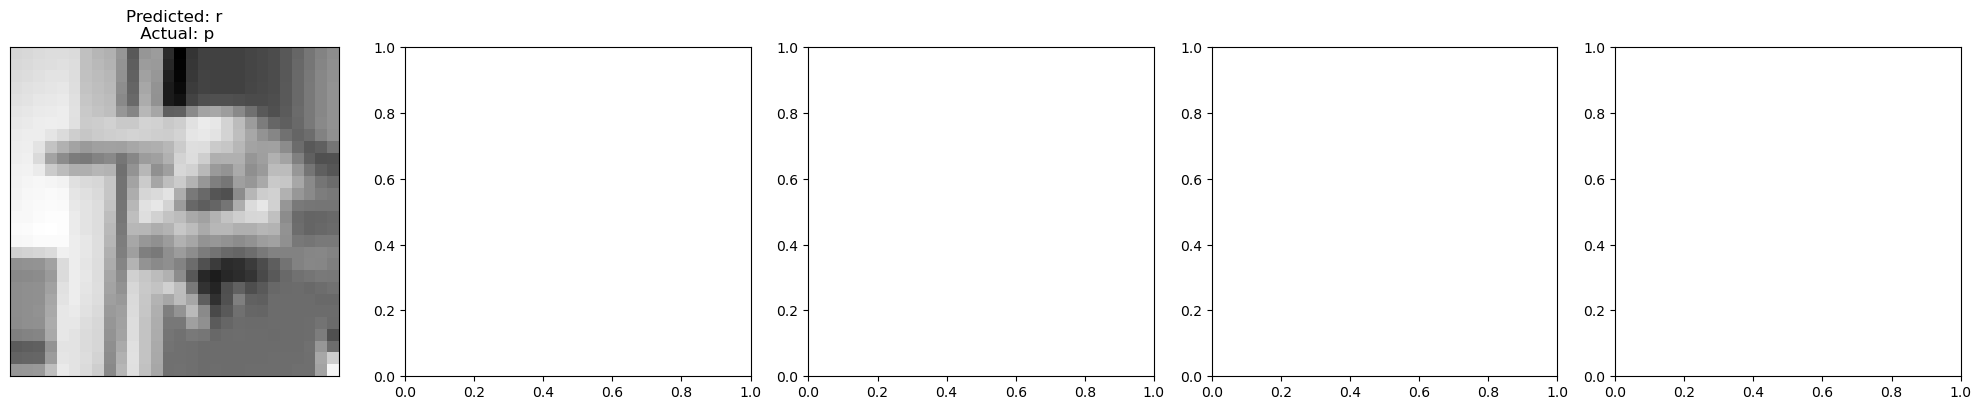

In [47]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20,4*rows))

ax = axes.flatten()

for i, image in enumerate(X_val[incorrect_photos]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    p = pred_y[incorrect_photos][i]
    prediction = alphabet[p]

    # Get actual label
    t = y_val[incorrect_photos][i]
    actual = alphabet[t.astype(np.int32)]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

**Comment:**
There is an unclear background which may have confused the model resulting in a misclassification

### Assessing Odds Ratio for each Letter
Creating plots of odds ratio to determine pixels which the model places greater importance on when it performs its classification for each given letter.

In [48]:
# Coefficient for each pixel
letter_coef = my_final_model.coef_

fig, axes = plt.subplots(6,4, figsize=(80, 120))

for i,coef in enumerate(letter_coef):
    plt.subplot(6,4,i+1)
    # To take the exponential each coefficient to output odds ratio
    plt.imshow(np.exp(coef).reshape(28,28) ,cmap='BuPu')
    plt.title(alphabet[i].upper(),fontsize='50')
    plt.xticks([])
    plt.yticks([])
plt.show()

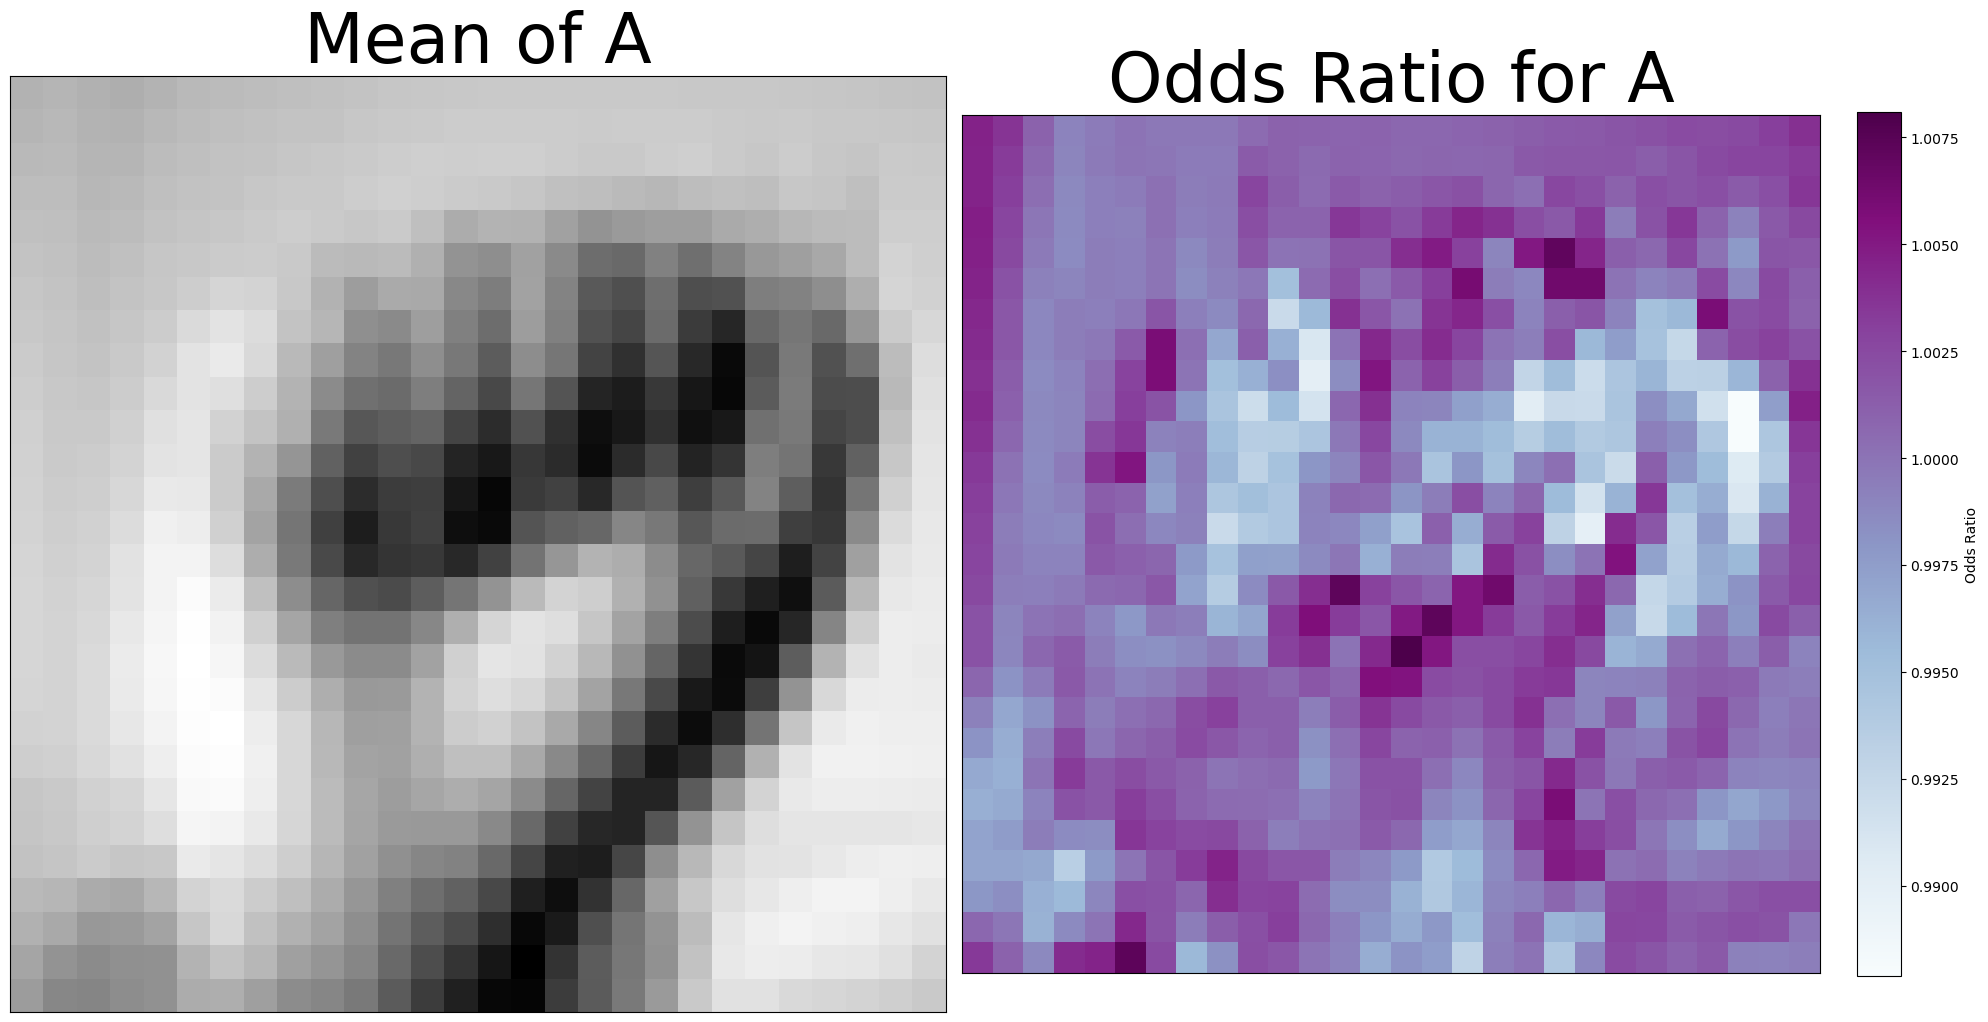

In [49]:
# Getting coefficients again to pass into my new function
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='A')

**Comment:** The darker ares in the odds ratio image show pixel intentistites at that particualr location are the most defining for the given letter (in this case A). Areas which are lighter show areas of commonality between the different signs, for example letters A, E, M and N are all similar as they are closed fists with minor differences in finger placement. The odds ratio for these four images would show a slight cross over in locations which are lightest above.

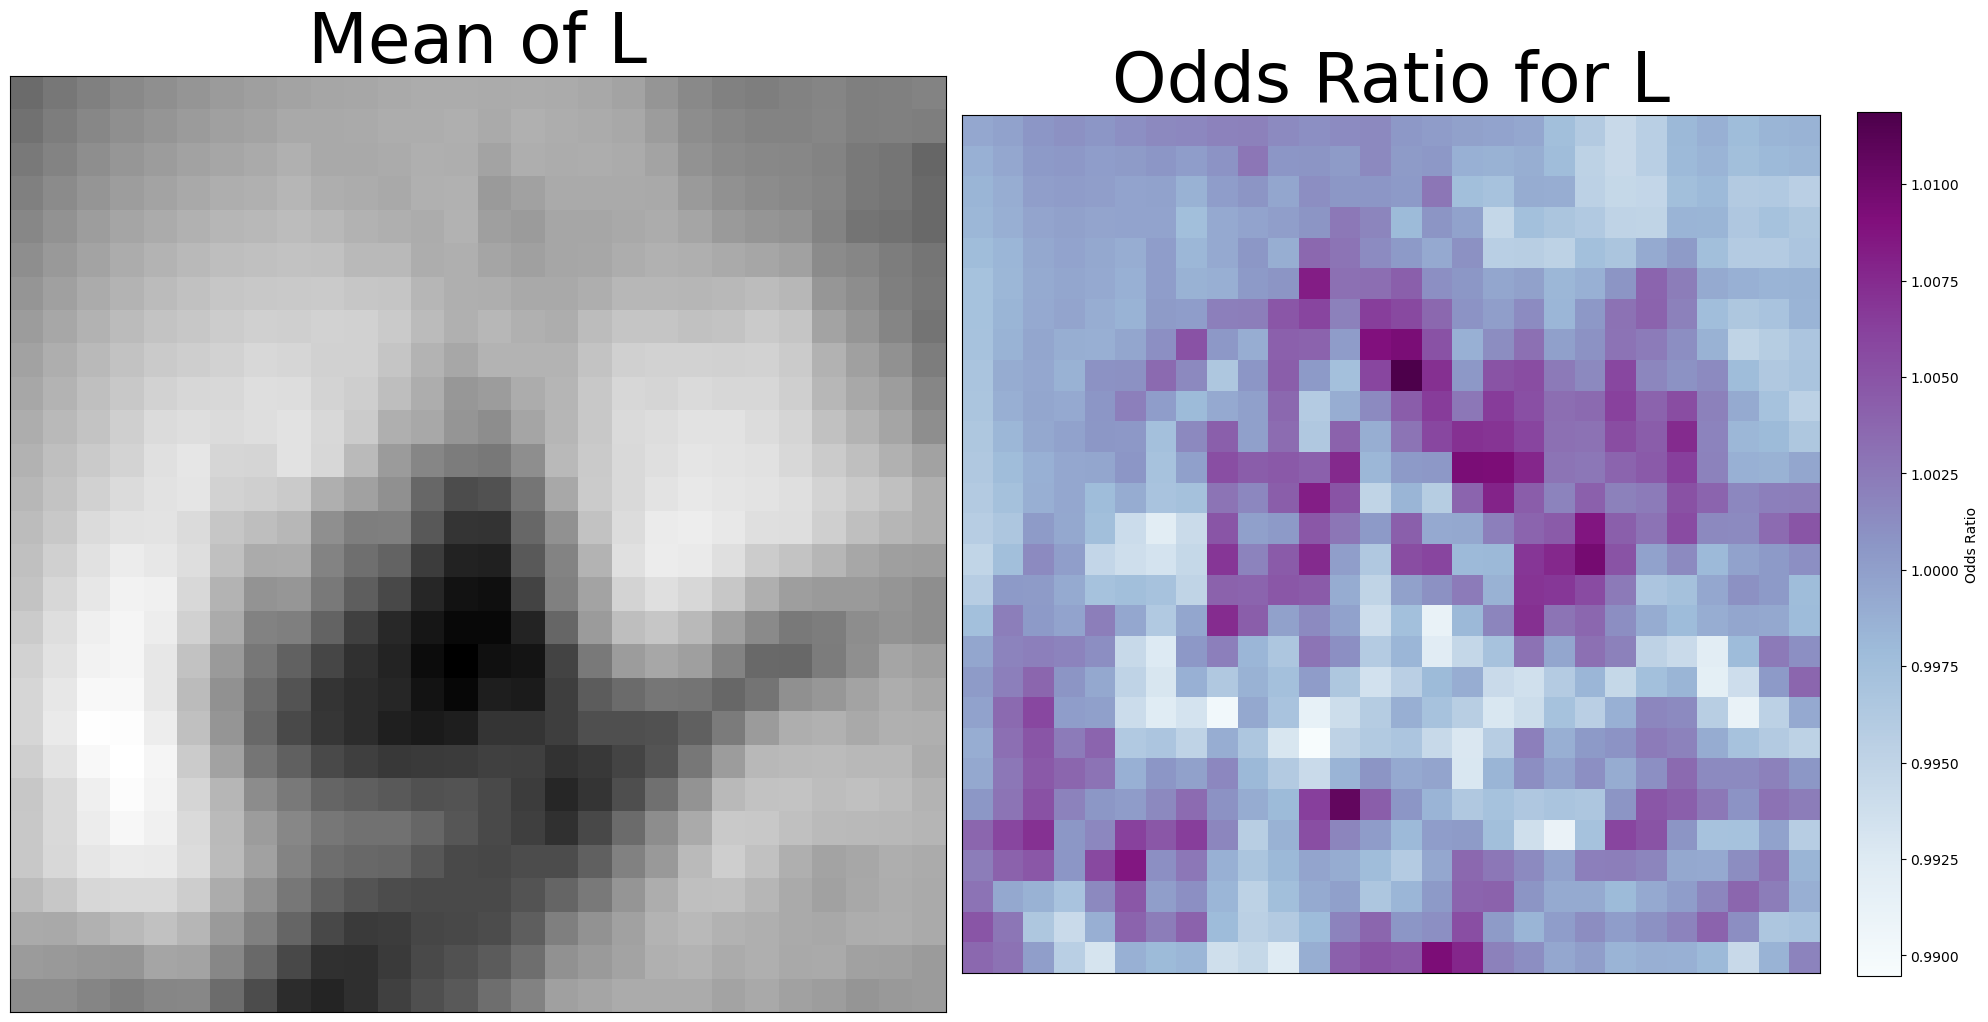

In [50]:
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='l')

### Testing an New Unseen Input Image

In [2]:
from keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

ModuleNotFoundError: No module named 'keras'

In [ ]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [ ]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [ ]:
# Reshaping to have dimesntions (1,784) -> to match X_train/X_test dimensions
test_img = image_array.reshape(1,28*28)

In [ ]:
my_final_model.predict(test_img)

array([22])

In [ ]:
alphabet[my_final_model.predict(test_img)[0]]

'x'